In [1]:
import sys
import os
sys.path.append('../src/')
from vega_model import VEGA
from utils import *
import torch
import pandas as pd
import scanpy as sc
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)
torch.manual_seed(0)
from sklearn.manifold import TSNE
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
# Reload pathway
pathway_dict = read_gmt('../data/hallmarks.gmt')
n = 5
pathway_list = list(pathway_dict.keys())+['UNANNOTATED_'+str(k) for k in range(n)]
#pathway_mask = create_pathway_mask(adata_train.var.index.tolist(), pathway_dict, add_missing=True, fully_connected=True)

In [ ]:
res = np.load('../trained_models/mixseq/10CV_vega_Trametinib_DMSO_24hr_expt3_res.npy', allow_pickle=True).item()
best_f = 0
best_l = 99999
for k,v in res.items():
    l = v['best_valid_loss']
    print(k, l)
    if l < best_l:
        best_f = k
        best_l = l

## Extract one dataset for test and example

In [3]:
import itertools
train_data = sc.read('../data/mixseq/Trametinib_DMSO_24hr_expt3.h5ad')
pathway_mask = create_pathway_mask(train_data.var.index.tolist(), pathway_dict, add_missing=n, fully_connected=True)
vae = VEGA(pathway_mask=pathway_mask, positive_decoder=True)
vae.load_state_dict(torch.load('../trained_models/mixseq/vega_Trametinib_DMSO_24hr_expt3_fold_%s.pt'%(best_f),map_location=torch.device('cpu')))
# Set to eval
vae.eval()
z = vae.to_latent(torch.Tensor(train_data.X.A)).detach().numpy()
pathway_encoded_df = pd.DataFrame(data=z, index=train_data.obs.index.tolist(), columns=pathway_list)

0.5
Constraining decoder to positive weights


In [4]:
tsne_coord = TSNE(n_components=2, random_state=42).fit_transform(z)
tsne_df = pd.DataFrame({'tSNE-1':tsne_coord[:,0], 'tSNE-2':tsne_coord[:,1],
                        'Cell Line':train_data.obs['singlet_ID'], 'Condition':train_data.obs['condition']})

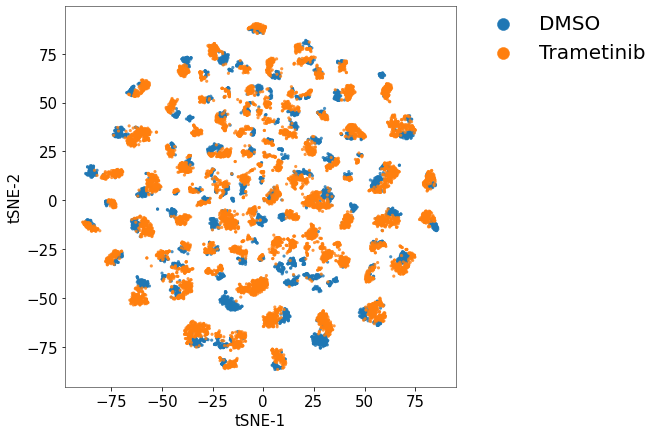

In [5]:
plt.figure(figsize=[7,7])
sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Condition', data=tsne_df, linewidth=0, alpha=0.8, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('../paper/figures/fig2-a-tra.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Arrow version
list_arrow = []
cl_name = []
for cl in train_data.obs['singlet_ID'].unique():
    cl_name.append(cl)
    mask_dmso = (train_data.obs['singlet_ID'] == cl) & (train_data.obs['condition'] == 'DMSO')
    mask_tram = (train_data.obs['singlet_ID'] == cl) & (train_data.obs['condition'] == 'Trametinib')
    median_dmso = np.median(tsne_coord[mask_dmso,:], axis=0)
    median_tram = np.median(tsne_coord[mask_tram,:], axis=0)
    d = median_tram - median_dmso
    list_arrow.append((median_dmso[0], median_dmso[1], d[0], d[1]))

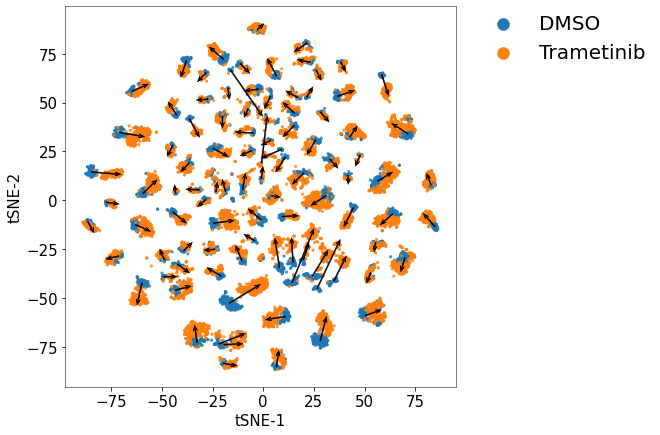

In [7]:
plt.figure(figsize=[7,7])
sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Condition', data=tsne_df, linewidth=0, alpha=0.8, s=10)
for a in list_arrow:
    plt.arrow(a[0],a[1],a[2],a[3], width=0.5, head_width=2, overhang=0.6, color='k', alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('../paper/figures/fig2-a-tra-arrow.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

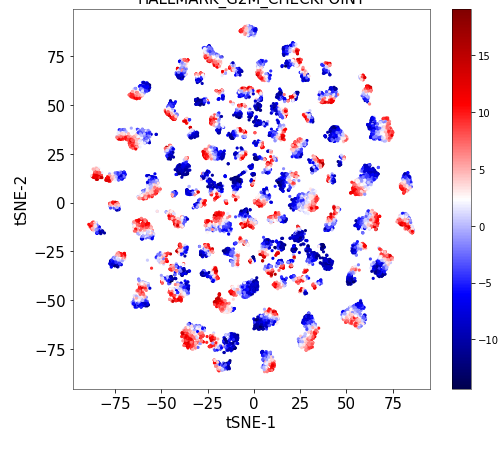

In [9]:
plt.figure(figsize=[8,7])
plt.scatter(tsne_df['tSNE-1'], tsne_df['tSNE-2'], alpha = 1, linewidths=0,
            c = pathway_encoded_df['HALLMARK_G2M_CHECKPOINT'], marker='o', s=10, cmap = 'seismic')
cbar = plt.colorbar()
plt.title('HALLMARK_G2M_CHECKPOINT', fontsize=15)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('../paper/figures/fig2-b-tra-g2m.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Other drugs

In [35]:
import pickle
drug_list = ['Dabrafenib', 'Navitoclax', 'BRD3379']
l_tsne_df = []
arrow_dict = {}
for drug in drug_list:
    np.random.seed(0)
    torch.manual_seed(0)
    train_data = sc.read('../data/mixseq/'+drug+'_DMSO_24hr_expt3.h5ad')
    pathway_mask = create_pathway_mask(train_data.var.index.tolist(), pathway_dict, add_missing=n, fully_connected=True)
    vae = VEGA(pathway_mask=pathway_mask, positive_decoder=True)
    vae.load_state_dict(torch.load('../trained_models/mixseq/vega_'+drug+'_DMSO_24hr_expt3_fold_0.pt',map_location=torch.device('cpu')))
    # Set to eval
    vae.eval()
    z = vae.to_latent(torch.Tensor(train_data.X.A)).detach().numpy()
    pathway_encoded_df = pd.DataFrame(data=z, index=train_data.obs.index.tolist(), columns=pathway_list)
    tsne_coord = TSNE(n_components=2, random_state=42).fit_transform(z)
    tsne_df = pd.DataFrame({'tSNE-1':tsne_coord[:,0], 'tSNE-2':tsne_coord[:,1],
                            'Cell Line':train_data.obs['singlet_ID'], 'Condition':train_data.obs['condition']})
    tsne_df.to_csv('../paper/'+drug+'_tsne_coord.csv', index=True, header=True)
    l_tsne_df.append(tsne_df)
    # Arrow version
    list_arrow = []
    cl_name = []
    for cl in train_data.obs['singlet_ID'].unique():
        cl_name.append(cl)
        mask_dmso = (train_data.obs['singlet_ID'] == cl) & (train_data.obs['condition'] == 'DMSO')
        mask_tram = (train_data.obs['singlet_ID'] == cl) & (train_data.obs['condition'] == drug)
        median_dmso = np.median(tsne_coord[mask_dmso,:], axis=0)
        median_tram = np.median(tsne_coord[mask_tram,:], axis=0)
        d = median_tram - median_dmso
        list_arrow.append((median_dmso[0], median_dmso[1], d[0], d[1]))
    # to dict
    arrow_dict[drug] = list_arrow
    

# Pickle arrows
with open('../paper/tsne_arrows.pkl', 'wb') as f:
    pickle.dump(arrow_dict, f)
    

0.5
Constraining decoder to positive weights
0.5
Constraining decoder to positive weights
0.5
Constraining decoder to positive weights


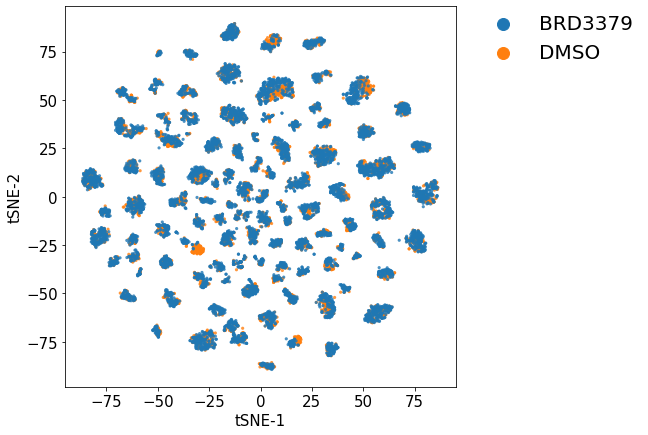

In [38]:
plt.figure(figsize=[7,7])
sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Condition', data=l_tsne_df[2], linewidth=0, alpha=0.8, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

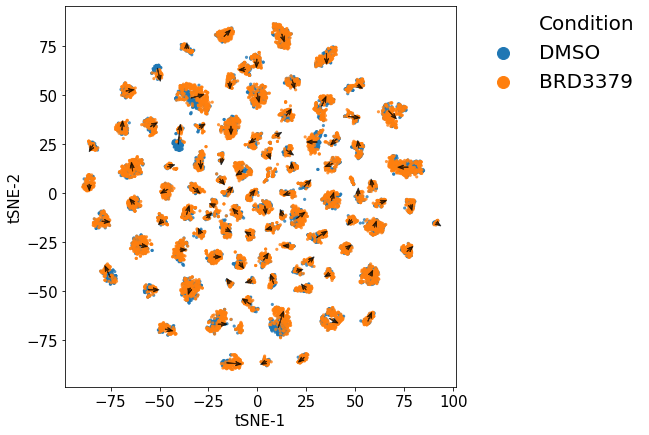

In [64]:
# tSNE plot with arrows for any other drugs
plt.figure(figsize=[7,7])
sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Condition', data=tsne_df, linewidth=0, alpha=0.8, s=10)
for a in list_arrow:
    plt.arrow(a[0],a[1],a[2],a[3], width=0.000001, head_width=2, overhang=0.6, color='k', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#plt.savefig('supp-brd-arrow.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Analysis of Bayes Factors

In [20]:
df_res_all = pd.DataFrame(index=pathway_list)
np.random.seed(4)
data_dirname = '../data/mixseq/'
model_dirname = '../trained_models/mixseq/'
list_res = os.listdir(model_dirname)
list_cv_out = [f for f in list_res if '10CV' in f]
# Iterate over different datasets
for res_out in list_cv_out:
    # Get dataset name, load, and get best fold for 10CV
    prefix = res_out.split('.')[0]
    prefix = '_'.join(prefix.split('_')[2:-1])
    data_name = prefix+'.h5ad'
    drug_name = prefix.split('_')[0]
    print('Analysis for '+drug_name)
    print(prefix)
    fold_dict = np.load(model_dirname+res_out, allow_pickle=True).item()
    best_k = {k:fold_dict[k]['best_valid_loss'] for k in fold_dict.keys()}
    best_k = min(best_k, key=best_k.get)
    train_data = sc.read(data_dirname+data_name)
    # Load mask and model
    pathway_mask = create_pathway_mask(train_data.var.index.tolist(), pathway_dict, add_missing=n, fully_connected=True)
    vae = VEGA(pathway_mask=pathway_mask, positive_decoder=True)
    vae.load_state_dict(torch.load(model_dirname+'vega_'+prefix+'_fold_'+str(best_k)+'.pt',map_location=torch.device('cpu')))
    vae.eval()
    # Do diff expr in latent space by pair drug/cell line
    data_ctrl = train_data[train_data.obs['condition']=='DMSO',:].copy()
    data_stim = train_data[train_data.obs['condition']==drug_name,:].copy()
    # Loop over cell lines
    for cell_line in train_data.obs['singlet_ID'].unique():
        data_stim_cl = data_stim[data_stim.obs['singlet_ID']==cell_line, :].copy()
        data_ctrl_cl = data_ctrl[data_ctrl.obs['singlet_ID']==cell_line, :].copy()
        if sparse.issparse(train_data.X):
            data_stim_cl.X = data_stim_cl.X.A
            data_ctrl_cl.X = data_ctrl_cl.X.A
        dfe_res = vae.bayesian_diff_exp(data_stim_cl, data_ctrl_cl, n_samples=5000, use_permutations=True, n_permutations=10000)
        # Store in df for later
        df_res_all[cell_line+'/'+drug_name] = dfe_res['bayes_factor']

Analysis for BRD3379
BRD3379_DMSO_24hr_expt3_deep
0.5
Constraining decoder to positive weights
Analysis for Dabrafenib
Dabrafenib_DMSO_24hr_expt3_deep
0.5
Constraining decoder to positive weights
Analysis for Trametinib
Trametinib_DMSO_24hr_expt3_deep
0.5
Constraining decoder to positive weights
Analysis for Navitoclax
Navitoclax_DMSO_24hr_expt3_deep
0.5
Constraining decoder to positive weights


In [30]:
df_res_all.to_csv('../paper/mixseq-cl-bf-deep.csv', sep=',', index=True, header=True)

## Clustering analysis for experiment 3

In [6]:
#reload if necessary
df_res_all = pd.read_csv('../paper/mixseq-cl-bf-deep.csv', sep=',', header=0, index_col=0)
cl_feat = pd.read_csv('../data/mixseq/Trametinib_24hr_expt3_CL_features.csv', sep=',')

In [7]:
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch
# retrieve clusters using fcluster 
d = sch.distance.pdist(df_res_all.T, metric='correlation')
L = sch.linkage(d, method='complete')
clusters = sch.fcluster(L, 0.5*d.max(), 'distance')

/home/ubuntu/anaconda3/envs/torch_env/lib/python3.6/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(860.9999999999999, 0.5, 'Hallmark Pathways')

<Figure size 720x360 with 0 Axes>

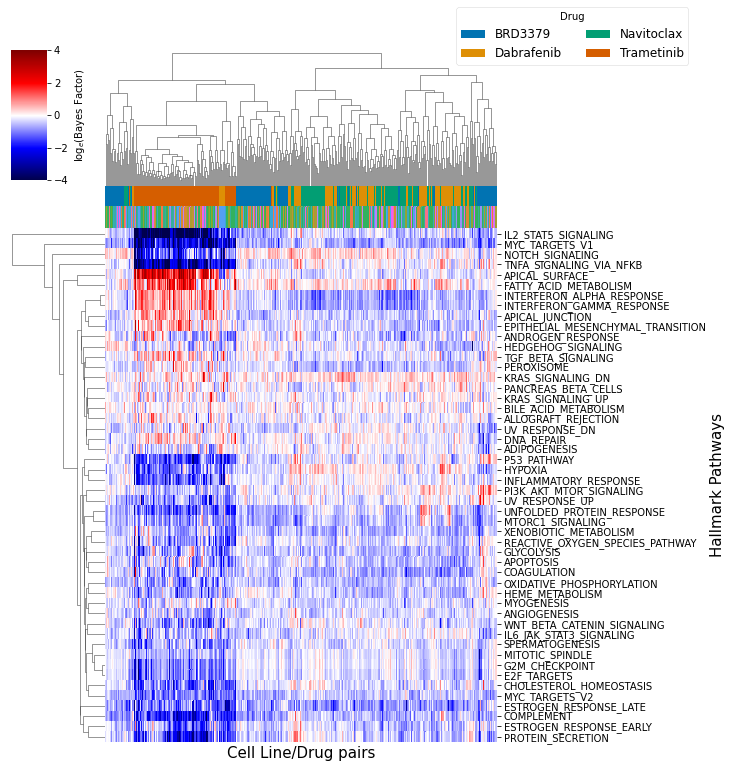

In [9]:
# COlor drug and tissue
drug_lbl = np.array([f.split('/')[1] for f in list(df_res_all)])
lut1 = dict(zip(np.unique(drug_lbl), sns.color_palette("colorblind",len(set(drug_lbl)))))
drug_colors = [lut1[k.split('/')[1]] for k in list(df_res_all)]

cell_lbl = np.array([f.split('/')[0] for f in list(df_res_all)])
lut2 = dict(zip(np.unique(cell_lbl), sns.color_palette("Spectral", len(set(cell_lbl)))))
cell_colors = [lut2[k.split('/')[0]] for k in list(df_res_all)]

tissue_lbl = np.array(['_'.join(f.split('/')[0].split('_')[1:]) for f in list(df_res_all)])
lut3 = dict(zip(np.unique(tissue_lbl), sns.color_palette("husl", len(set(tissue_lbl)))))
tissue_colors = [lut3['_'.join(k.split('/')[0].split('_')[1:])] for k in list(df_res_all)]

plt.figure(figsize=[10,5])
#sns.clustermap(df_res_all, cmap='seismic', col_colors=[drug_colors, cell_colors], center=0)
cg = sns.clustermap(df_res_all, col_linkage=L, cmap='seismic', col_colors=[drug_colors, tissue_colors], center=0, vmin=-4, vmax=4,
                   linewidths=0, xticklabels=False, yticklabels=True,
                   cbar_kws={'label': r'$\log_e$(Bayes Factor)'})

for label in np.unique(drug_lbl):
    cg.ax_row_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)

l2 = cg.ax_row_dendrogram.legend(title='Drug', loc="center", ncol=2, bbox_to_anchor=(0.8,1),
                                 bbox_transform=plt.gcf().transFigure, fontsize=12)


ax = cg.ax_heatmap
ax.set_xlabel('Cell Line/Drug pairs', fontsize=15)
ax.set_ylabel('Hallmark Pathways', fontsize=15)
#plt.savefig('../paper/figures/fig2-c-hm-tissue.pdf', format='pdf', dpi=300, bbox_inches='tight')

### Individual Heatmap

<Figure size 720x360 with 0 Axes>

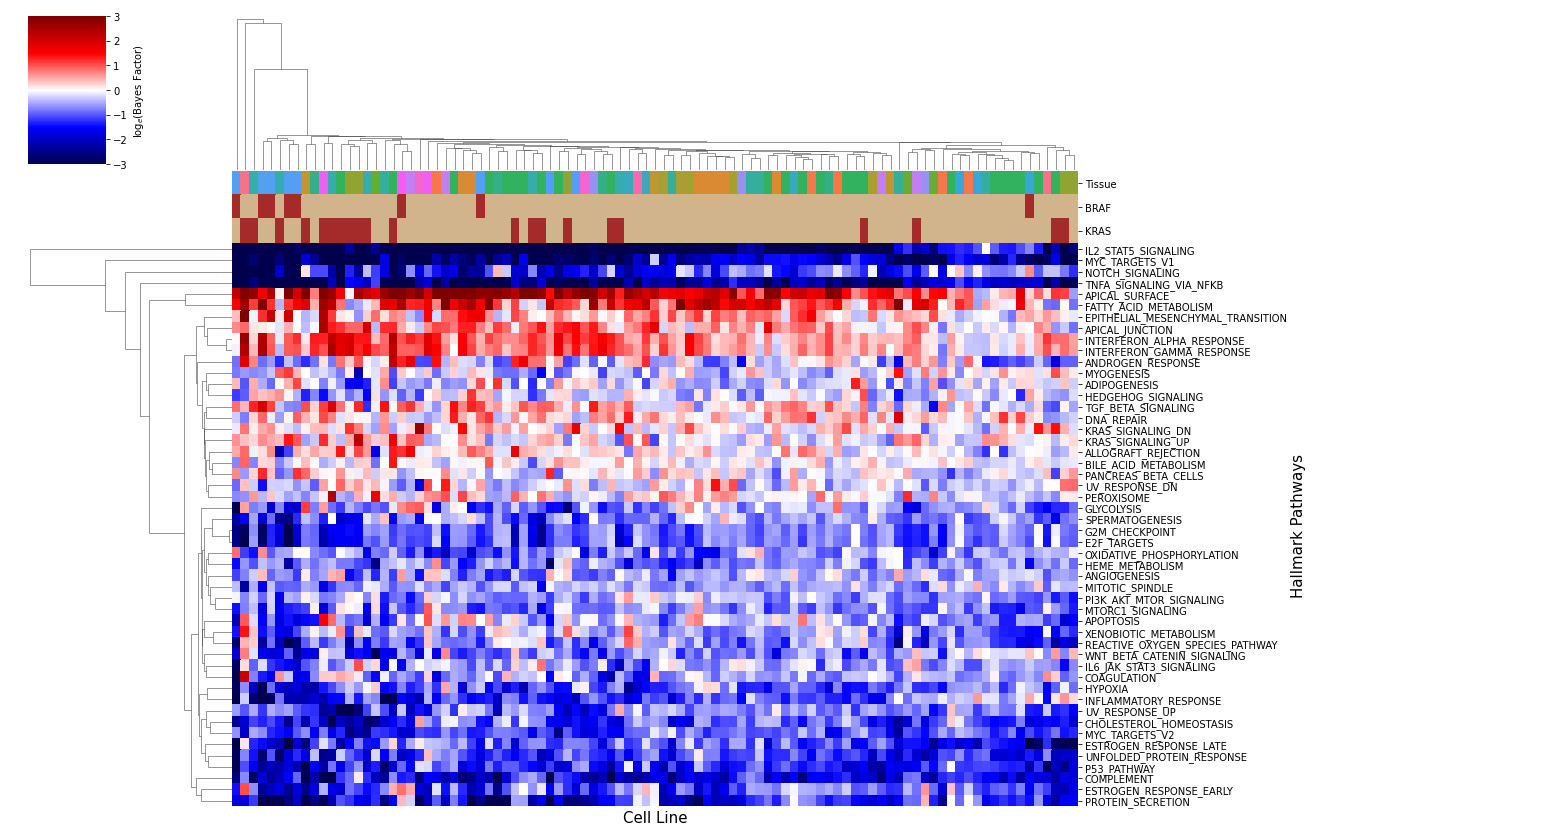

<Figure size 720x360 with 0 Axes>

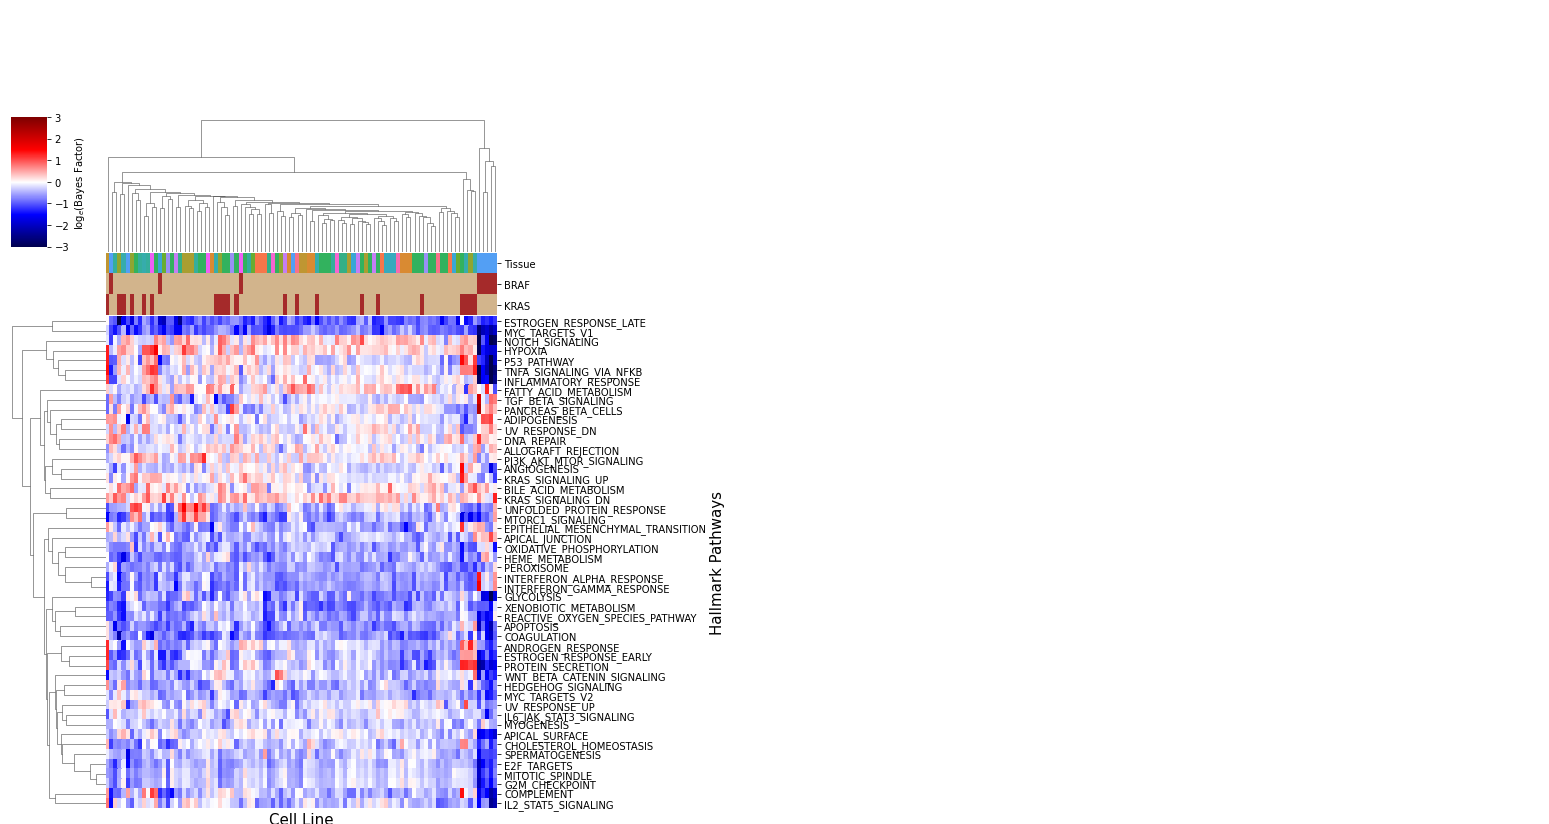

<Figure size 720x360 with 0 Axes>

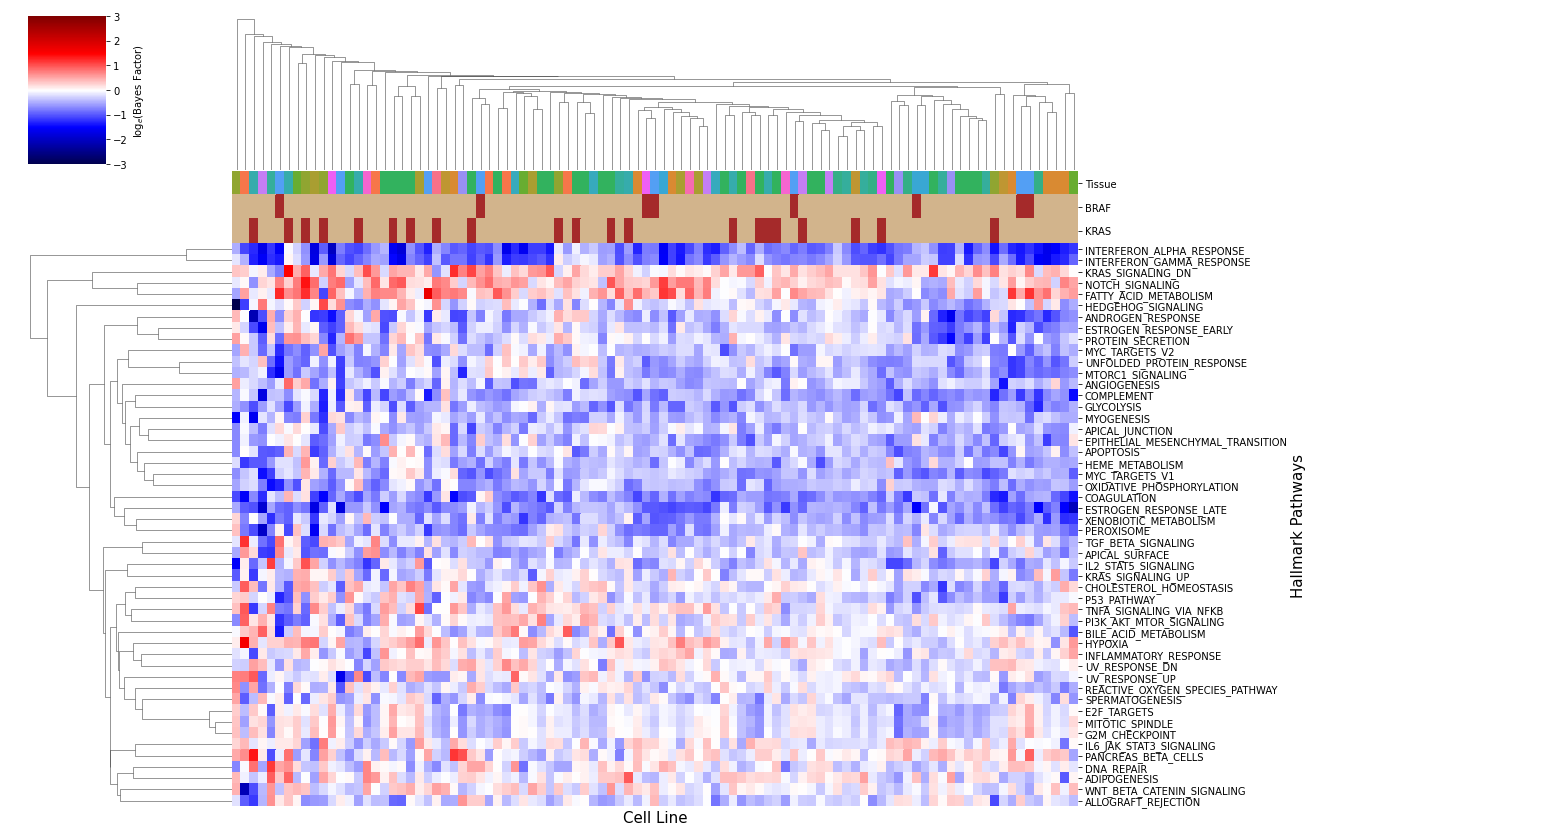

<Figure size 720x360 with 0 Axes>

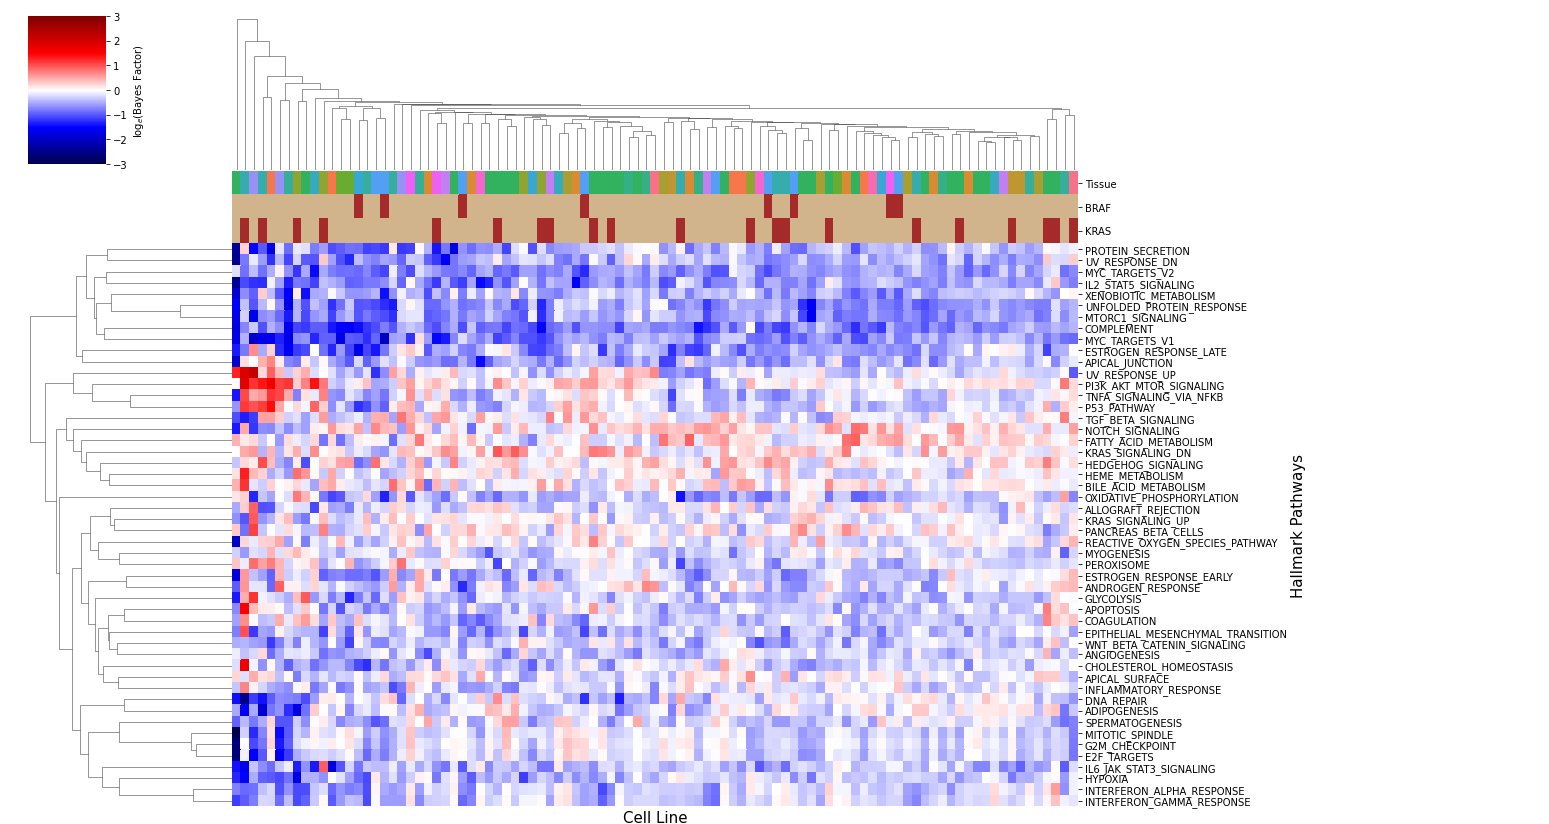

In [51]:
# Reload if necessary
heatmap_df = pd.read_csv('../paper/mixseq-cl-bf-deep.csv', sep=',', header=0, index_col=0)
drug_list = ['Trametinib', 'Dabrafenib', 'Navitoclax', 'BRD3379']

tissue_lbl = np.array(['_'.join(f.split('/')[0].split('_')[1:]) for f in list(heatmap_df)])
lut3 = dict(zip(np.unique(tissue_lbl), sns.color_palette("husl", len(set(tissue_lbl)))))
tissue_colors = [lut3['_'.join(k.split('/')[0].split('_')[1:])] for k in list(heatmap_df)]

braf_mut = cl_feat[cl_feat['in_pool']][['BRAF_MUT','CCLE_ID']]
dict_braf_mut = dict(zip(braf_mut['CCLE_ID'], braf_mut['BRAF_MUT']))
braf_colors = ['tan' if dict_braf_mut[c]==0. else 'brown' for c in cell_lbl]

kras_mut = cl_feat[cl_feat['in_pool']][['KRAS_MUT','CCLE_ID']]
dict_kras_mut = dict(zip(braf_mut['CCLE_ID'], kras_mut['KRAS_MUT']))
kras_colors = ['tan' if dict_kras_mut[c]==0. else 'brown' for c in cell_lbl]

hras_mut = cl_feat[cl_feat['in_pool']][['HRAS_MUT','CCLE_ID']]
dict_hras_mut = dict(zip(hras_mut['CCLE_ID'], hras_mut['HRAS_MUT']))
hras_colors = ['tan' if dict_hras_mut[c]==0. else 'brown' for c in cell_lbl]

all_annot_colors = pd.DataFrame({'Tissue':tissue_colors,
                                 'BRAF':braf_colors,
                                 'KRAS':kras_colors})
all_annot_colors.index = list(heatmap_df)

for drug in drug_list:
    if drug=='Dabrafenib':
        to_color = mut_colors
    else:
        to_color = tissue_colors
    
    sub_col = [c for c in list(heatmap_df) if drug in c]
    sub_df = heatmap_df[sub_col]
    plt.figure(figsize=[10,5])
    cg = sns.clustermap(sub_df, cmap='seismic', center=0, vmin=-3, vmax=3, col_colors=all_annot_colors,
                       linewidths=0, xticklabels=False, yticklabels=True,
                       cbar_kws={'label': r'$\log_e$(Bayes Factor)'})
    for label in np.unique(tissue_lbl):
        cg.ax_row_dendrogram.bar(0, 0, color=lut3[label], label=label, linewidth=0)

    l2 = cg.ax_row_dendrogram.legend(title='Tissue', loc="center", ncol=10, bbox_to_anchor=(0.8,-0.1),
                                     bbox_transform=plt.gcf().transFigure, fontsize=12)
    ax = cg.ax_heatmap
    ax.set_xlabel('Cell Line', fontsize=15)
    ax.set_ylabel('Hallmark Pathways', fontsize=15)
    #plt.savefig('../paper/figures/Supp_'+drug+'_hm-tissue-mut-withleg.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()